In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

from consts import * 
from transform2D import *
from astra_modules import *

from scipy import optimize
from scipy.integrate import ode
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
import re

In [2]:
workdir='E:\\Lixiangkun\\Work\\ERL-THz\\S2E'
os.chdir(workdir)

In [ ]:
# Injector
def Injector():
    '''DCgun-S1-S2-Buncher-S3-SC1-SC2'''
    pos0=0
    coor=np.array([[0,0.25,1.4,1.7,2.3,3.0,3.826],[0,0,0,0,0,0,0]])
    alpha=15.0*np.pi/180.
    for i in np.arange(len(coor[:,0])):
        r=transform2D(coor[i,:],alpha)

In [136]:
# Merger
def Merger():
    '''q01-q02-b1-q1-b2-q2-b3-q11-q12'''
    Lquad,Rquad=0.09,2.15e-2
    D01,D02,D03=0.08,0.25-Lquad,0.18
    D1,D2=0.8,0.2
    D11,D12,D13=0.2,0.25-Lquad,0.1

    R=600e-3
    alpha,beta=15.0*np.pi/180.,7.5*np.pi/180.

    p0,dd=5.0,0.6 # 5.0
    qz01,qx01=p0+D01+Lquad/2,0
    qz02,qx02=qz01+Lquad+D02,0
    qz1,qx1=p0+dd+R*np.sin(alpha)+(D1+Lquad/2)*np.cos(alpha),-R*(1-np.cos(alpha))-(D1+Lquad/2)*np.sin(alpha)
    qz2,qx2=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)+D2+Lquad/2.,-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)

    bz1,bx1=p0+dd+R*np.sin(beta),-R*(1-np.cos(beta))
    bz2,bx2=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*np.cos(alpha)-R*np.sin(beta),-2*R*(1-np.cos(alpha))-(D1+Lquad+D2)*np.sin(alpha)+R*(1-np.cos(beta))
    bz3,bx3=p0+dd+2*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+R*np.sin(beta),qx2-R*(1-np.cos(beta))

    qz11,qx11=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad/2.)*np.cos(alpha),\
              qx2-R*(1-np.cos(alpha))-(D11+Lquad/2.)*np.sin(alpha)
    qz12,qx12=p0+dd+3*R*np.sin(alpha)+(D1+Lquad+D2)*(1+np.cos(alpha))+(D11+Lquad+D12+Lquad/2.)*np.cos(alpha),\
              qx2-R*(1-np.cos(alpha))-(D11+Lquad+D12+Lquad/2.)*np.sin(alpha)

    coor=np.array([[0,0.25,1.4,1.7,2.3,3.0,3.826,qz01,qz02,bz1,qz1,bz2,qz2,bz3,qz11,qz12],\
                   [0,0,0,0,0,0,0,qx01,qx02,bx1,qx1,bx2,qx2,bx3,qx11,qx12],\
                   [15,15,15,15,15,15,15,15,15,7.5,0,7.5,15,7.5,0,0]]).T
    q_coor=np.array([[qz01,qz02,qz1,qz2,qz11,qz12],[qx01,qx02,qx1,qx2,qx11,qx12],[15,15,0,15,0,0]]).T
    b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3],[7.5,7.5,7.5]]).T

    coor[:,1]=-coor[:,1]
    b_coor[:,1]=-b_coor[:,1]
    q_coor[:,1]=-q_coor[:,1]
    for i in np.arange(len(coor[:,0])):
        r=transform2D(coor[i,0:2],alpha)
        coor[i,0:2]=r
    for i in np.arange(len(b_coor[:,0])):
        r=transform2D(b_coor[i,0:2],alpha)
        b_coor[i,0:2]=r
    for i in np.arange(len(q_coor[:,0])):
        r=transform2D(q_coor[i,0:2],alpha)
        q_coor[i,0:2]=r
    
    zz,xx=5.*np.cos(alpha),5.*np.sin(alpha)
    coor[:,0]=coor[:,0]-4.5-zz#4.8
    b_coor[:,0]=b_coor[:,0]-4.5-zz#4.8
    q_coor[:,0]=q_coor[:,0]-4.5-zz#4.8
    coor[:,1]=coor[:,1]+0.4986+xx
    b_coor[:,1]=b_coor[:,1]+0.4986+xx
    q_coor[:,1]=q_coor[:,1]+0.4986+xx

    #plt.figure(figsize=(10,2))
    #plt.plot(coor[:,0],coor[:,1],'r-')
    #plt.plot(q_coor[:,0],q_coor[:,1],'b*')
    #plt.plot(b_coor[:,0],b_coor[:,1],'g*')
    #plt.axis([-4.5,0,-0.3,0.6])
    #plt.grid()
    #plt.show()

    return b_coor,q_coor,coor

In [128]:
# Arc1
def Arc1():
    '''q01-q02-b1-q1-q2-b2-q2-q1-b3-q11-q12'''
    Lquad,Rquad=0.09,2.15e-2

    R,alpha,beta=600e-3,60,0
    Lbend=R*alpha/180*np.pi
    #print tran.Pc,B1

    D01,D02,D03=0.3,0.4-Lquad,0.3
    D1,D2,D3=0.3,0.4-Lquad,0.3
    D1,D2,D3=0.4575,0.3009-Lquad,0.4857
    D11,D12,D13=0.3,0.4-Lquad,0.3

    pos,R,alpha=4,0.6,60./180*np.pi

    L=D01+Lquad/2
    qz01,qx01=pos+L,0
    
    qz02,qx02=qz01+D02+Lquad,0
    
    L=D01+Lquad+D02+Lquad+D03
    bz1,bx1=pos+L+R*np.sin(alpha/2.),R*(np.cos(alpha/2)-1)

    ## end of bending1
    ZB1,XB1=pos+L+R*np.sin(alpha),R*(np.cos(alpha)-1)

    L=D1+Lquad/2
    qz1,qx1=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
    L=D1+Lquad+D2+Lquad/2
    qz2,qx2=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)

    L=D1+Lquad+D2+Lquad+D3
    bz2,bx2=ZB1+L*np.cos(alpha)+R*(1-np.cos(alpha/2.)),XB1-L*np.sin(alpha)-R*np.sin(alpha/2.)

    ## end of bending2
    ZB2,XB2=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)-2*R*np.sin(alpha/2.)

    L=D3+Lquad/2
    qz3,qx3=ZB2-L*np.cos(alpha),XB2-L*np.sin(alpha)
    L=D3+Lquad+D2+Lquad/2
    qz4,qx4=ZB2-L*np.cos(alpha),XB2-L*np.sin(alpha)

    L=D3+Lquad+D2+Lquad+D1
    ## end of bending3
    ZB3,XB3=ZB2-L*np.cos(alpha)-R*np.sin(alpha),XB2-L*np.sin(alpha)-R*(1-np.cos(alpha))

    bz3,bx3=ZB3+R*np.sin(alpha/2.),XB3+R*(1-np.cos(alpha/2.))

    L=D11+Lquad/2.
    qz11,qx11=ZB3-L,XB3

    L=D11+Lquad+D12+Lquad/2.
    qz12,qx12=ZB3-L,XB3

    q_coor=np.array([[qz01,qz02,qz1,qz2,qz3,qz4,qz11,qz12],[qx01,qx02,qx1,qx2,qx3,qx4,qx11,qx12],\
                    [0,0,60,60,120,120,180,180]]).T
    b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3],[30,90,150]]).T
    coor=np.array([[qz01,qz02,bz1,qz1,qz2,bz2,qz3,qz4,bz3,qz11,qz12],[qx01,qx02,bx1,qx1,qx2,bx2,qx3,qx4,bx3,qx11,qx12],\
                  [0,0,30,60,60,90,120,120,150,180,180]]).T

    #plt.figure(figsize=(5,5))
    #plt.plot(b_coor[:,0],b_coor[:,1],'r-*')
    #plt.plot(q_coor[:,0],q_coor[:,1],'b-*')
    #plt.grid()
    #plt.savefig('traj.eps')
    #plt.show()
    return b_coor,q_coor,coor

In [129]:
# Arc2
def Arc2():
    '''b1-q1-q2-b2-q2-q1-b3-q11-q12'''
    Lquad,Rquad=0.09,2.15e-2

    R,alpha,beta=600e-3,60,0
    Lbend=R*alpha/180*np.pi
    #print tran.Pc,B1

    D01,D02,D03=0.,0,0.
    D1,D2,D3=0.3,0.4-Lquad,0.3
    D1,D2,D3=0.4575,0.3009-Lquad,0.4857
    D11,D12,D13=0.3,0.4-Lquad,0.3

    pos,R,alpha=0,0.6,60./180*np.pi

    L=D01
    qz01,qx01=pos+L,0
    
    qz02,qx02=qz01+D02,0
    
    L=D01+D02+D03
    bz1,bx1=pos+L+R*np.sin(alpha/2.),R*(np.cos(alpha/2)-1)
 
    ## end of bending1
    ZB1,XB1=pos+L+R*np.sin(alpha),R*(np.cos(alpha)-1)

    L=D1+Lquad/2
    qz1,qx1=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)
    L=D1+Lquad+D2+Lquad/2
    qz2,qx2=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)

    L=D1+Lquad+D2+Lquad+D3
    bz2,bx2=ZB1+L*np.cos(alpha)+R*(1-np.cos(alpha/2.)),XB1-L*np.sin(alpha)-R*np.sin(alpha/2.)

    ## end of bending2
    ZB2,XB2=ZB1+L*np.cos(alpha),XB1-L*np.sin(alpha)-2*R*np.sin(alpha/2.)

    L=D3+Lquad/2
    qz3,qx3=ZB2-L*np.cos(alpha),XB2-L*np.sin(alpha)
    L=D3+Lquad+D2+Lquad/2
    qz4,qx4=ZB2-L*np.cos(alpha),XB2-L*np.sin(alpha)

    L=D3+Lquad+D2+Lquad+D1
    ## end of bending3
    ZB3,XB3=ZB2-L*np.cos(alpha)-R*np.sin(alpha),XB2-L*np.sin(alpha)-R*(1-np.cos(alpha))

    bz3,bx3=ZB3+R*np.sin(alpha/2.),XB3+R*(1-np.cos(alpha/2.))

    L=D11+Lquad/2.
    qz11,qx11=ZB3-L,XB3

    L=D11+Lquad+D12+Lquad/2.
    qz12,qx12=ZB3-L,XB3

    q_coor=np.array([[qz1,qz2,qz3,qz4,qz11,qz12],[qx1,qx2,qx3,qx4,qx11,qx12],[240,240,300,300,0,0]]).T
    b_coor=np.array([[bz1,bz2,bz3],[bx1,bx2,bx3],[210,270,330]]).T
    coor=np.array([[bz1,qz1,qz2,bz2,qz3,qz4,bz3,qz11,qz12],[bx1,qx1,qx2,bx2,qx3,qx4,bx3,qx11,qx12],\
                  [210,240,240,270,300,300,330,0,0]]).T

    q_coor[:,0]=-q_coor[:,0]-5.7
    b_coor[:,0]=-b_coor[:,0]-5.7
    coor[:,0]=-coor[:,0]-5.7
    q_coor[:,1]=-q_coor[:,1]-3.50695
    b_coor[:,1]=-b_coor[:,1]-3.50695
    coor[:,1]=-coor[:,1]-3.50695
    
    #plt.figure(figsize=(5,5))
    #plt.plot(b_coor[:,0],b_coor[:,1],'r-*')
    #plt.plot(q_coor[:,0],q_coor[:,1],'b-*')
    #plt.grid()
    #plt.savefig('traj.eps')
    #plt.show()
    return b_coor,q_coor,coor
#Arc2()

In [130]:
# Chicane
def Chicane():
    '''q01-q02-q03-b1-b2-b3-b4-q11-q12-q1-q2-q3'''
    pos0=0.
    alpha,beta=30*np.pi/180.,0*np.pi/180.

    D01,D02,D03,D04=0.3,0.3,0.3,0.5
    L0,L1,L2=0.3,0.64,0.3

    Lquad=0.09
    rho=L0/np.sin(alpha)
    dx=L1*np.sin(alpha)
    dz=L1*np.cos(alpha)

    b_coor=[]
    q_coor=[]

    qz01,qx02=D01+Lquad/2,0
    qz02,qx02=qz01+D02+Lquad,0
    qz03,qx03=qz02+D03+Lquad,0

    bz1,bz2x=qz03+Lquad/2+D04+L0/2,0
    bz2,bx2=bz1+L0/2+dz+L0/2,-2*rho*(1-np.cos(alpha))-dx
    bz3,bx3=bz2+L0/2+L2*2+L0/2,bx2
    bz4,bx4=bz3+L0/2+dz+L0/2,0

    qz11,qx11=5.0+Lquad/2,0
    qz12,qx12=qz11+0.3+Lquad,0

    #8.2-7.81267,0.3,0.3
    qz1,qx1=8.2+Lquad/2,0
    qz2,qx2=qz1+0.3+Lquad,0
    qz3,qx3=qz2+0.3+Lquad,0

    q_coor=np.array([[qz01,qz02,qz03,qz11,qz12,qz1,qz2,qz3],[qx01,qx02,qx03,qx11,qx12,qx1,qx2,qx3],[0,0,0,0,0,0,0,0]]).T
    b_coor=np.array([[bz1,bz2,bz3,bz4],[bx1,bx2,bx3,bx4],[0,0,0,0]]).T
    coor=np.array([[qz01,qz02,qz03,bz1,bz2,bz3,bz4,qz11,qz12,qz1,qz2,qz3],[qx01,qx02,qx03,bx1,bx2,bx3,bx4,qx11,qx12,qx1,qx2,qx3],\
                  [0,0,0,0,0,0,0,0,0,0,0,0]]).T
    
    # 起点：z=3.78786,x=-3.50695
    q_coor[:,0]=-q_coor[:,0]+3.78786
    b_coor[:,0]=-b_coor[:,0]+3.78786
    coor[:,0]=-coor[:,0]+3.78786
    
    q_coor[:,1]=-q_coor[:,1]-3.50695
    b_coor[:,1]=-b_coor[:,1]-3.50695
    coor[:,1]=-coor[:,1]-3.50695
    
    #print b_coor
    
    #plt.figure(figsize=(10,5))
    #plt.plot(b_coor[:,0],b_coor[:,1],'r-*')
    #plt.plot(q_coor[:,0],q_coor[:,1],'b-*')
    #plt.axis([3.5,7,-3.3,0.2])
    ###
    #plt.grid()
    #plt.savefig('traj.eps')
    
    return b_coor,q_coor,coor
#Chicane()

In [139]:
##
import matplotlib.patches as patches

LW=0.8
def add_quadrupole(axes,pos,width=90,height=120,alpha=0.*np.pi/180):
    zz,xx=pos[0],pos[1]
    rect=patches.Rectangle((zz-width/2,xx),width,height,fill=False,linewidth=LW)
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    rect.set_transform(t)
    axes.add_patch(rect)
def add_YAG(axes,pos,alpha=0.*np.pi/180,fill=False,color='k'):
    d,h,xoff=20,120,35
    zz,xx=pos[0],pos[1]
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    xy=np.array([[-d,d,0,-2*d],[d+xoff,d+xoff,-d+xoff,-d+xoff]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,fill=fill,color=color,linewidth=LW)
    poly.set_transform(t)
    axes.add_patch(poly)
    xy=np.array([[0,0],[d+xoff,d+xoff+h]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,fill=fill,linewidth=LW)
    poly.set_transform(t)
    axes.add_patch(poly)
def add_slits(axes,pos,alpha=0.*np.pi/180):
    d,h,xoff=20,120,35
    zz,xx=pos[0],pos[1]
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    xy=np.array([[-d,d,0,-2*d],[d+xoff,d+xoff,-d+xoff,-d+xoff]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,fill=False,linewidth=LW)
    poly.set_transform(t)
    axes.add_patch(poly)
    xy=np.array([[-1.25*d,0.75*d,0.5*d,-1.5*d,-1.75*d,0.25*d],[0.5*d+xoff,0.5*d+xoff,xoff,xoff,-0.5*d+xoff,-0.5*d+xoff]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,fill=False,closed=False,linewidth=LW)
    poly.set_transform(t)
    axes.add_patch(poly)
    xy=np.array([[0,0],[d+xoff,d+xoff+h]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,linewidth=LW)
    poly.set_transform(t)
    axes.add_patch(poly)
def add_BPM(axes,pos,r1=45,alpha=0.*np.pi/180):
    zz,xx=pos[0],pos[1]
    ellipse=patches.Ellipse(pos,width=r1,height=2*r1,angle=0,fill=False,linewidth=LW)
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    ellipse.set_transform(t)
    axes.add_patch(ellipse)    
def add_bend(axes,pos,a=100,b=100,h=100,alpha=22.5*np.pi/180):
    ''' 
        以偏转轨迹的中心为原点，给出偏转轨迹外的磁极面长度a，偏转轨迹内的磁极面长度b，
        以及沿半径方向的高度h，alp为偏转方向,，通常为偏转角一半
    '''
    zz,xx=pos[0],pos[1]
    xy=np.array([[-a/2.,-b/2.,b/2.,a/2.],[h/2.,-h/2.,-h/2.,h/2.]]).T
    xy[:,0]=xy[:,0]+zz
    xy[:,1]=xy[:,1]+xx
    poly=patches.Polygon(xy,fill=False,linewidth=LW)
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    poly.set_transform(t)
    axes.add_patch(poly)
def add_bend2(axes,pos,r1=270,r2=331,theta1=0,theta2=90):
    ''' 
       给出圆心，内外弧长的半径，起终点的角度（逆时针），这里的角度为degree
    '''
    zc,xc=pos[0],pos[1]
    xy1=np.array([[zc+r1*np.cos(theta1*np.pi/180.),xc+r1*np.sin(theta1*np.pi/180.)],\
                  [zc+r2*np.cos(theta1*np.pi/180.),xc+r2*np.sin(theta1*np.pi/180.)]])
    poly1=patches.Polygon(xy1,fill=False,linewidth=LW)
    arc1=patches.Arc(pos,width=2*r1,height=2*r1,angle=0,theta1=theta1,theta2=theta2)
    axes.add_patch(poly1)
    axes.add_patch(arc1)
    xy2=np.array([[zc+r1*np.cos(theta2*np.pi/180.),xc+r1*np.sin(theta2*np.pi/180.)],\
                  [zc+r2*np.cos(theta2*np.pi/180.),xc+r2*np.sin(theta2*np.pi/180.)]])
    poly2=patches.Polygon(xy2,fill=False,linewidth=LW)
    arc2=patches.Arc(pos,width=2*r2,height=2*r2,angle=0,theta1=theta1,theta2=theta2)
    axes.add_patch(poly2)
    axes.add_patch(arc2)
def add_steering(axes,pos,r1=35,r2=55,width=20,alpha=0):
    zz,xx=pos[0]-width/2.,pos[1]
    rect=patches.Rectangle((zz,xx+r1),width,r2-r1,fill=False,linewidth=LW)
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    rect.set_transform(t)
    axes.add_patch(rect)
    rect=patches.Rectangle((zz,xx-r1),width,r1-r2,fill=False,linewidth=LW)
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    rect.set_transform(t)
    axes.add_patch(rect)
def add_solenoid(axes,pos,r1=55,r2=106,width=124,alpha=0):
    zz,xx=pos[0]-width/2.,pos[1]
    t = mpl.transforms.Affine2D().rotate_around(zz,xx,alpha) + axes.transData
    rect=patches.Rectangle((zz,xx+r1),width,r2-r1,fill=False,linewidth=LW)
    rect.set_transform(t)
    axes.add_patch(rect)
    poly=patches.Polygon(np.array([[zz,xx+r1],[zz+width,xx+r2]]))
    poly.set_transform(t)
    axes.add_patch(poly)
    poly=patches.Polygon(np.array([[zz+width,xx+r1],[zz,xx+r2]]))
    poly.set_transform(t)
    axes.add_patch(poly)
    rect=patches.Rectangle((zz,xx-r1),width,r1-r2,fill=False,linewidth=LW)
    rect.set_transform(t)
    axes.add_patch(rect)
    poly=patches.Polygon(np.array([[zz,-xx-r1],[zz+width,-xx-r2]]))
    poly.set_transform(t)
    axes.add_patch(poly)
    poly=patches.Polygon(np.array([[zz+width,-xx-r1],[zz,-xx-r2]]))
    poly.set_transform(t)
    axes.add_patch(poly)
def add_arrow(axes,pos,length,alpha=0):
    zz,xx=pos[0],pos[1]
    dz,dx=length*np.cos(alpha),length*np.sin(alpha)
    arrow=patches.Arrow(zz, xx, dz, dx, head_width=0.05, head_length=0.1)
    axes.add_patch(arrow)

[]

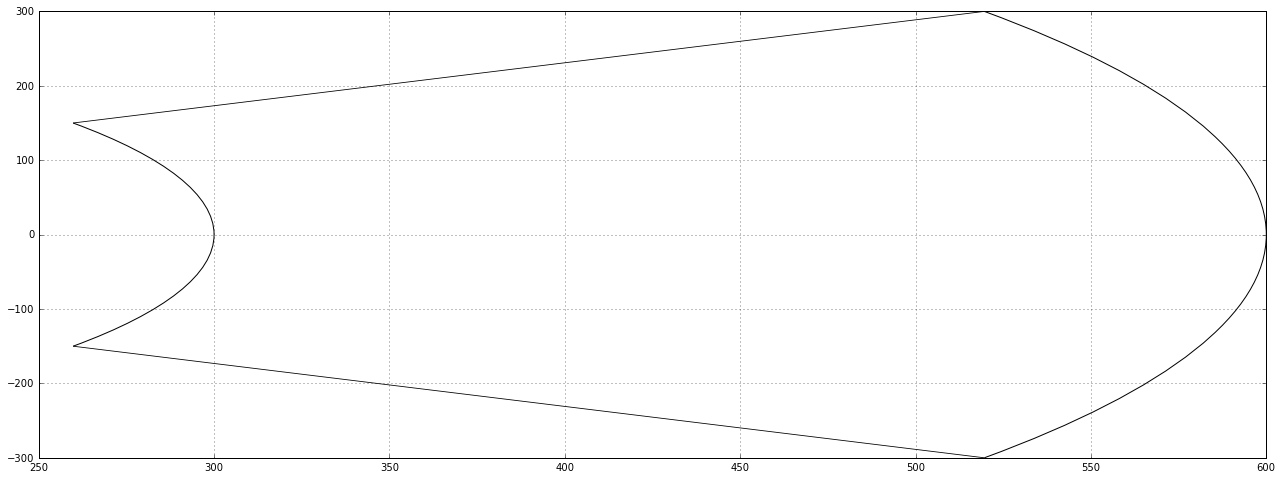

In [141]:
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(22,8))
#axes.axis([-200,5200,-450,450])
#axes.axis([-200,10800,-2000,2000])
axes.grid()

add_bend2(axes,[0,0],r1=300,r2=600,theta1=-30,theta2=30)
axes.plot()

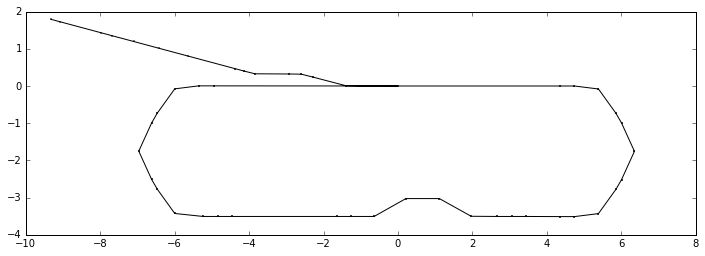

In [150]:
b1,q1,c1=Merger()
b2,q2,c2=Arc1()
b3,q3,c3=Chicane()
b4,q4,c4=Arc2()

c0=np.array([[0,0,0]])

b_coor=np.concatenate((b1,b2,b3,b4))
q_coor=np.concatenate((q1,q2,q3,q4))
coor=np.concatenate((c1,c2,c3,c4,c0))

fig,axes=plt.subplots(figsize=(12,4),frameon=False)
axes.plot(coor[:,0],coor[:,1],'ko-',ms=1)
axes.plot(b_coor[:,0],b_coor[:,1],'r*',ms=1)
axes.plot(q_coor[:,0],q_coor[:,1],'b*',ms=1)
#axes.axis('off')
#axes.grid()
fig.savefig('ERL-traj.eps')